<a href="https://colab.research.google.com/github/utkuyucel/Deep-Learning/blob/master/Keras_Cifar10_TPU_Swallow_model_70_Accuracy_after_training_50_epochs_on_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from keras.utils import to_categorical, plot_model
import numpy as np
import os

(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [14]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.73.129.34:8470


In [0]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
def train_input_fn(batch_size=1024):
  # Girişleri bir veri kümesine dönüştür. 
  dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

  # Karıştır, tekrar et ve batch (küme) örnekleri 
  dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

  # veri kümesine.
  return dataset

In [0]:
def test_input_fn(batch_size=1024):
  # Girişleri bir veri kümesine dönüştür. .
  dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

  # sKarıştır, tekrar et ve batch (küme) örnekleri 
  dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

  # veri kümesine.
  return dataset

In [0]:
def model(X_input):
  
  X_input = tf.keras.Input((32,32,3))
  
  X1 = tf.keras.layers.Conv2D(32, (2,2), strides = (1,1),padding = "same", name = "conv0")(X_input)
  X1 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn0")(X1)  
  X1 = tf.keras.layers.Activation("relu")(X1)  
  X1 = tf.keras.layers.Conv2D(32, (3,3), strides = (1,1),padding = "same", name = "conv1")(X1) 
  X1 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn1")(X1) 
  X1 = tf.keras.layers.Activation("relu")(X1)
  X1 = tf.keras.layers.Conv2D(32, (2,2), strides = (1,1), padding = "same", name = "conv2")(X1)
  X1 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn2")(X1)
  X1 = tf.keras.layers.Activation("relu")(X1)
  
  X2 = tf.keras.layers.Conv2D(32, (1,1), strides = (1,1),padding = "same", name = "conv3")(X_input)  
  X2 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn3")(X2)
  X2 = tf.keras.layers.Activation("relu")(X2) 
  X2 = tf.keras.layers.Conv2D(32, (5,5), strides = (1,1),padding = "same", name = "conv4")(X2)  
  X2 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn4")(X2)
  X2 = tf.keras.layers.Activation("relu")(X2)
  X2 = tf.keras.layers.Conv2D(32, (5,5), strides = (1,1),padding = "same", name = "conv5")(X2)  
  X2 = tf.keras.layers.BatchNormalization(axis = 3, name = "bn5")(X2)
  X2 = tf.keras.layers.Activation("relu")(X2)
  
  X3 = tf.keras.layers.MaxPooling2D((1,1), strides = (1,1), name = "max_pool0")(X_input)
  X3 = tf.keras.layers.Conv2D(32, (5,5), strides = (1,1), padding = "same", name = "conv6")(X3)
  X3 = tf.keras.layers.BatchNormalization()(X3)
  X3 = tf.keras.layers.Activation("relu")(X3)
  
  X = tf.keras.layers.concatenate([X1,X2,X3])
  
  X4 = tf.keras.layers.Conv2D(32, (5,5), strides = (1,1), padding = "same", name = "conv7")(X_input)
  X4 = tf.keras.layers.BatchNormalization()(X4)
  X4 = tf.keras.layers.Activation("relu")(X4)
  X5 = tf.keras.layers.Conv2D(32, (4,4), strides = (1,1), padding = "same",name = "conv8" )(X)
  X5 = tf.keras.layers.BatchNormalization()(X5)
  X5 = tf.keras.layers.Activation("relu")(X5)  
  
  Y2 = tf.keras.layers.concatenate([X4,X5])
  
  F1 = tf.keras.layers.Conv2D(32, (5,5), strides = (1,1), padding = "same", name = "conv9")(Y2)
  F1 = tf.keras.layers.BatchNormalization()(F1)
  F1 = tf.keras.layers.Activation("relu")(F1)
  
  top = tf.keras.layers.concatenate([X,Y2,F1])
  
  P1 = tf.keras.layers.Conv2D(32, (7,7), strides = (1,1), padding = "same", name = "conv10")(Y2)
  P1 = tf.keras.layers.BatchNormalization()(P1)
  P1 = tf.keras.layers.Activation("relu")(P1)
  P2 = tf.keras.layers.Conv2D(64, (8,8), strides = (1,1), padding = "same", name = "conv11")(P1)
  P2 = tf.keras.layers.BatchNormalization()(P2)
  P2 = tf.keras.layers.Activation("relu")(P2)
  
  last = tf.keras.layers.concatenate([top,P1,P2])
  
  X = tf.keras.layers.Flatten()(last)
  X = tf.keras.layers.Dense(32, activation = "relu", name = "d1")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  
  X = tf.keras.layers.Dense(10, activation = "softmax", name = "fc")(X)
  
  
  model = tf.keras.models.Model(inputs = X_input, outputs = X)
  
  return model

In [0]:
model = model((32,32,3))

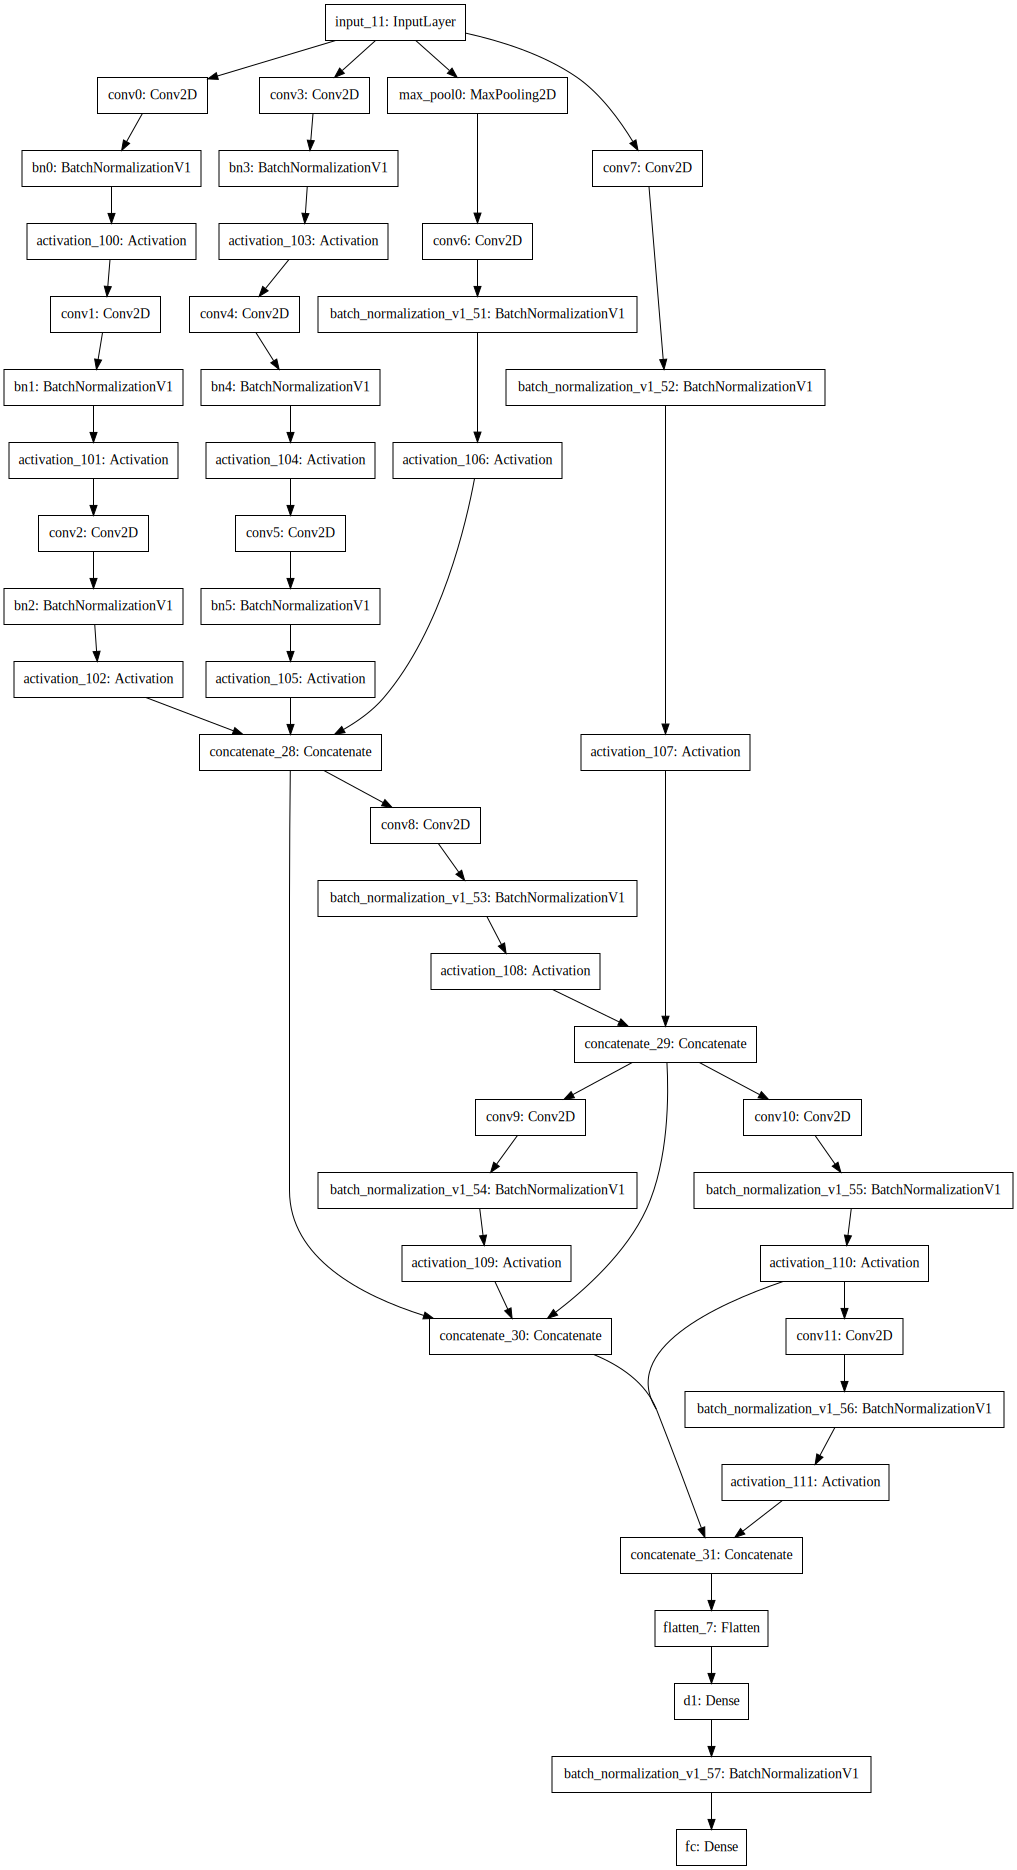

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [0]:
tpu_model.load_weights('./MNIST_TPU_1024.h5')

In [0]:
model.compile(optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
             loss = "categorical_crossentropy",
             metrics = ["acc"])

In [51]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.73.129.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 16297241073185263248)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1454377551568334393)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11718704630848561624)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18389063608214805396)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5197069596074187447)
INFO:tensorflow:*** Available Device: _DeviceAttributes

InvalidArgumentError: ignored

In [44]:
tpu_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 32)   416         input_11[0][0]                   
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 32, 32, 32)   128         input_11[0][0]                   
__________________________________________________________________________________________________
bn0 (BatchNormalizationV1)      (None, 32, 32, 32)   128         conv0[0][0]                      
__________________________________________________________________________________________________
bn3 (Batch

In [52]:
 tpu_model.fit(
  train_input_fn,
  steps_per_epoch = 60,
  epochs=20,
)

Epoch 1/20
INFO:tensorflow:Setting weights on TPU model.
60/60 [==============================] - 38s 637ms/step - loss: 9.5224e-04 - acc: 1.0000
Epoch 2/20
60/60 [==============================] - 38s 637ms/step - loss: 8.6736e-04 - acc: 1.0000
Epoch 3/20
60/60 [==============================] - 38s 632ms/step - loss: 7.9669e-04 - acc: 1.0000
Epoch 4/20
60/60 [==============================] - 38s 629ms/step - loss: 7.2960e-04 - acc: 1.0000
Epoch 5/20
60/60 [==============================] - 38s 631ms/step - loss: 6.7373e-04 - acc: 1.0000
Epoch 6/20
60/60 [==============================] - 38s 630ms/step - loss: 6.2224e-04 - acc: 1.0000
Epoch 7/20
60/60 [==============================] - 38s 634ms/step - loss: 5.7583e-04 - acc: 1.0000
Epoch 8/20
60/60 [==============================] - 38s 630ms/step - loss: 5.3601e-04 - acc: 1.0000
Epoch 9/20
60/60 [==============================] - 38s 632ms/step - loss: 4.9697e-04 - acc: 1.0000
Epoch 10/20
60/60 [==============================] - 3

In [53]:
tpu_model.save_weights('./MNIST_TPU_1024.h5', overwrite=True)

INFO:tensorflow:Copying TPU weights to the CPU


In [54]:
tpu_model.evaluate(test_input_fn, steps = 100)

100/100 [==============================] - 26s 261ms/step - loss: 1.1714 - acc: 0.7028


[1.1714481925964355, 0.70276976]